<a href="https://colab.research.google.com/github/Vamshi-Nallaguntla/DQN-Algorithm/blob/main/DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# To install the gymnasium library
!pip install gymnasium

In [ ]:
import gymnasium as gym
import numpy as np                                  # Import NumPy for numerical operations
import tensorflow as tf                             # For building and training DL models
from tensorflow.keras import Sequential             # For building models layer by layer
from tensorflow.keras.layers import Dense, Input    # Layers in the model
import matplotlib.pyplot as plt                     # For plotting reward graph

In [ ]:
# Initialize the CartPole environment
env = gym.make("CartPole-v1")

In [ ]:
# Hyperparameters
learning_rate = 0.001
episodes = 1000
gamma = 0.99  # Discount factor
epsilon = 1.0  # Exploration rate
epsilon_decay = 0.995
min_epsilon = 0.01
batch_size = 64  # Replay buffer batch size
replay_buffer_size = 10000

In [ ]:
# Neural Network for Q-learning
model = Sequential([
    Input(shape=(env.observation_space.shape[0],)),
    Dense(24, activation='relu'),
    Dense(24, activation='relu'),
    Dense(env.action_space.n, activation='linear')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')

In [ ]:
# Target model
target_model = tf.keras.models.clone_model(model)
target_model.set_weights(model.get_weights())

# Replay buffer
replay_buffer = []

def add_to_replay_buffer(state, action, reward, next_state, done):
    """Store experience in replay buffer."""
    if len(replay_buffer) >= replay_buffer_size:
        replay_buffer.pop(0)
    replay_buffer.append((state, action, reward, next_state, done))

def sample_from_replay_buffer(batch_size):
    """Sample a random batch from the replay buffer."""
    indices = np.random.choice(len(replay_buffer), batch_size)
    return [replay_buffer[i] for i in indices]

# Training Loop
reward_history = []

In [ ]:
@tf.function
def predict_action(state):
    """Predict Q-values and return the best action."""
    q_values = model(state[np.newaxis], training=False)  # Predict without training
    return tf.argmax(q_values[0])  # Return the index of the max Q-value

@tf.function
def train_on_batch(states, actions, rewards, next_states, dones):
    """Perform a single training step on the replay buffer batch."""
    # Predict Q-values for next states using the target model
    next_q_values = target_model(next_states, training=False)
    max_next_q_values = tf.reduce_max(next_q_values, axis=1)

    # Calculate target Q-values
    targets = rewards + gamma * max_next_q_values * (1 - dones)

    # Compute current Q-values and update
    with tf.GradientTape() as tape:
        q_values = model(states, training=True)
        # Gather the Q-values corresponding to actions
        indices = tf.stack([tf.range(tf.shape(actions)[0]), actions], axis=1)
        predicted_q_values = tf.gather_nd(q_values, indices)
        loss = tf.reduce_mean(tf.square(targets - predicted_q_values))  # MSE loss

    # Apply gradients
    grads = tape.gradient(loss, model.trainable_variables)
    model.optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss


# Training Loop
for episode in range(episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False

    while not done:
        # Epsilon-greedy policy
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = predict_action(tf.constant(state, dtype=tf.float32)).numpy()

        # Step through the environment
        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward

        # Add experience to the replay buffer
        add_to_replay_buffer(state, action, reward, next_state, done)

        # Sample from replay buffer and train the model
        if len(replay_buffer) >= batch_size:
            batch = sample_from_replay_buffer(batch_size)
            states, actions, rewards, next_states, dones = zip(*batch)

            # Convert to tensors
            states = tf.constant(states, dtype=tf.float32)
            next_states = tf.constant(next_states, dtype=tf.float32)
            actions = tf.constant(actions, dtype=tf.int32)
            rewards = tf.constant(rewards, dtype=tf.float32)
            dones = tf.constant(dones, dtype=tf.float32)

            # Train on batch
            train_on_batch(states, actions, rewards, next_states, dones)

        state = next_state

    # Decay epsilon
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

    # Update target model weights periodically
    if episode % 10 == 0:
        target_model.set_weights(model.get_weights())

    reward_history.append(total_reward)

    # Logging progress for every episode
    print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}, Epsilon: {epsilon:.4f}")

env.close()

Episode 1/1000, Total Reward: 22.0, Epsilon: 0.9950
Episode 2/1000, Total Reward: 25.0, Epsilon: 0.9900
Episode 3/1000, Total Reward: 12.0, Epsilon: 0.9851
Episode 4/1000, Total Reward: 46.0, Epsilon: 0.9801
Episode 5/1000, Total Reward: 9.0, Epsilon: 0.9752
Episode 6/1000, Total Reward: 11.0, Epsilon: 0.9704
Episode 7/1000, Total Reward: 13.0, Epsilon: 0.9655
Episode 8/1000, Total Reward: 34.0, Epsilon: 0.9607
Episode 9/1000, Total Reward: 46.0, Epsilon: 0.9559
Episode 10/1000, Total Reward: 11.0, Epsilon: 0.9511
Episode 11/1000, Total Reward: 11.0, Epsilon: 0.9464
Episode 12/1000, Total Reward: 17.0, Epsilon: 0.9416
Episode 13/1000, Total Reward: 16.0, Epsilon: 0.9369
Episode 14/1000, Total Reward: 11.0, Epsilon: 0.9322
Episode 15/1000, Total Reward: 34.0, Epsilon: 0.9276
Episode 16/1000, Total Reward: 21.0, Epsilon: 0.9229
Episode 17/1000, Total Reward: 29.0, Epsilon: 0.9183
Episode 18/1000, Total Reward: 12.0, Epsilon: 0.9137
Episode 19/1000, Total Reward: 30.0, Epsilon: 0.9092
Epi

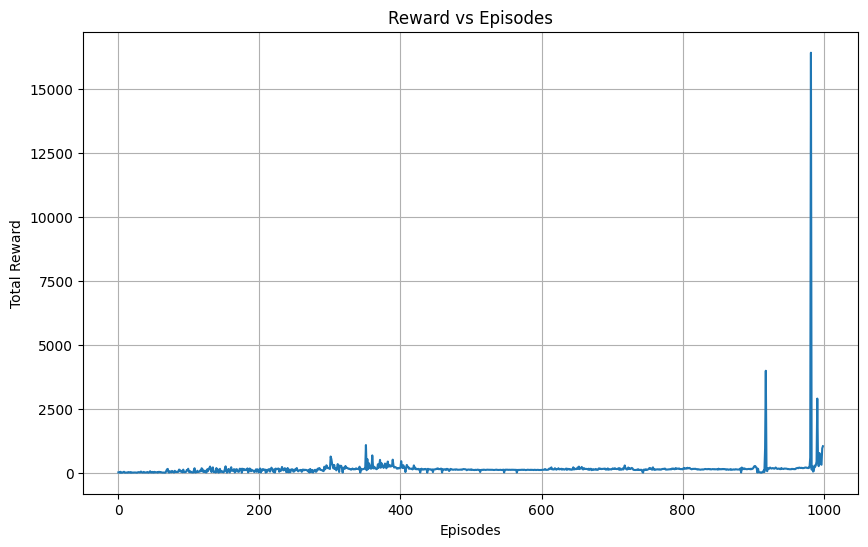

In [ ]:
# Plotting the Reward Graph
plt.figure(figsize=(10, 6))
plt.plot(reward_history)
plt.title("Reward vs Episodes") # Set title
plt.xlabel("Episodes")          # Set x-label
plt.ylabel("Total Reward")      # Set y-label
plt.grid(True)
plt.show()

In [ ]:
model.summary() # Display the architecture of the neural network model

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 24)                  │             120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 24)                  │             600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 2)                   │              50 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,312 (9.04 KB)

 Trainable params: 770 (3.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,542 (6.03 KB)